![image](https://raw.githubusercontent.com/IBM/watson-machine-learning-samples/master/cloud/notebooks/headers/watsonx-Prompt_Lab-Notebook.png)
# Use watsonx to tune IBM `granite-13b-instruct-v2` model with Car Rental Company customer satisfaction document

#### Disclaimers

- Use only Projects and Spaces that are available in watsonx context.


## Notebook content

This notebook contains the steps and code to demonstrate support of prompt tuning in watsonx.

Some familiarity with Python is helpful. This notebook uses Python 3.10.


## Learning goal

The goal of this notebook is to demonstrate how to:
- upload of dataset with prompts to container (project)
- trigger prompt tuning process
- review of prompt tuning process details/results
- deploy prompt-tuned model/asset
- evaluation (via inference) of prompt-tuned model/asset


## Contents

This notebook contains the following parts:

- [Setup](#setup)
- [Data loading](#data_loading)
- [Initialize experiment](#initialize)
- [Run Prompt Tuning](#run_tuning)
- [Prompt Tuning details](#run_details)
- [Deploy](#deploy)
- [Foundation Models Inference](#models_inference)
- [Analyze the satisfaction](#predict)
- [Summary and next steps](#summary)

<a id="setup"></a>
## Set up the environment

Before you use the sample code in this notebook, you must perform the following setup tasks:

-  Contact with your Cloud Pack for Data administrator and ask him for your account credentials

### Install and import the `datasets` and dependencies

In [ ]:
!pip install ibm-watsonx-ai | tail -n 1
!pip install scikit-learn | tail -n 1
!pip install matplotlib | tail -n 1
!pip install wget | tail -n 1

### Connection to WML

Authenticate the Watson Machine Learning service on IBM Cloud Pack for Data. You need to provide platform `url`, your `username` and `api_key`.

In [2]:
username = 'PASTE YOUR USERNAME HERE'
api_key = 'PASTE YOUR API_KEY HERE'
url = 'PASTE THE PLATFORM URL HERE'

In [3]:
credentials = {
    "username": username,
    "apikey": api_key,
    "url": url,
    "instance_id": 'openshift',
    "version": '4.8'
}

Alternatively you can use `username` and `password` to authenticate WML services.

```
wml_credentials = {
    "username": ***,
    "password": ***,
    "url": ***,
    "instance_id": 'openshift',
    "version": '4.8'
}

```

### Defining the project id
The Foundation Model requires project id that provides the context for the call. We will obtain the id from the project in which this notebook runs. Otherwise, please provide the project id.

In [4]:
import os

try:
    project_id = os.environ["PROJECT_ID"]
except KeyError:
    project_id = input("Please enter your project_id (hit enter): ")

Create an instance of APIClient with authentication details.

In [5]:
from ibm_watsonx_ai import APIClient

client = APIClient(credentials)

To be able to interact with all resources available in Watson Machine Learning, you need to set **project_id** which you will be using.

In [6]:
client.set.default_project(project_id)

'SUCCESS'

<a id="data_loading"></a>
## Data loading

This example uses the Consumer Financial Protection Bureau training dataset. 

In [7]:
filename = 'car_rental_prompt_tuning_training_data.json'

Download training data from git repository and create data assets.

In [8]:
import wget
import os

url = "https://raw.github.com/IBM/watson-machine-learning-samples/master/cloud/data/prompt_tuning/car_rental_prompt_tuning_training_data.json"
if not os.path.isfile(filename):
    wget.download(url)

asset_details = client.data_assets.create(name=filename, file_path=filename)
asset_id = client.data_assets.get_id(asset_details)

Creating data asset...
SUCCESS


In [9]:
print(asset_id)

a370d191-0027-42bc-956d-6afaac2ad6d1


Define connection information to training data.

In [10]:
from ibm_watsonx_ai.helpers import DataConnection

data_conn = DataConnection(data_asset_id=asset_id)

<a id="initialize"></a>
## Initialize experiment 

In [11]:
from ibm_watsonx_ai.experiment import TuneExperiment

experiment = TuneExperiment(credentials, project_id=project_id)

All avaliable tasks are presented under `Tasks` Enum

In [12]:
{task.name: task.value for task in experiment.Tasks}

{'QUESTION_ANSWERING': 'question_answering',
 'SUMMARIZATION': 'summarization',
 'RETRIEVAL_AUGMENTED_GENERATION': 'retrieval_augmented_generation',
 'CLASSIFICATION': 'classification',
 'GENERATION': 'generation',
 'CODE_GENERATION_AND_CONVERSION': 'code',
 'EXTRACTION': 'extraction',
 'TRANSLATION': 'translation'}

Define `prompt_tuner` parameters. 

**Action:** For parameters details, see <a href="https://ibm.github.io/watsonx-ai-python-sdk/tune_experiment.html#ibm_watsonx_ai.experiment.fm_tune.TuneExperiment.prompt_tuner" target="_blank" rel="noopener no referrer">documentation</a>.

In [13]:
prompt_tuner = experiment.prompt_tuner(name="granite-13b-instruct-v2 prompt tuning - python SDK",
                                       task_id=experiment.Tasks.CLASSIFICATION,
                                       base_model='ibm/granite-13b-instruct-v2',
                                       accumulate_steps=16,
                                       batch_size=8,
                                       learning_rate=0.0002,
                                       max_input_tokens=128,
                                       max_output_tokens=2,
                                       num_epochs=6,
                                       tuning_type=experiment.PromptTuningTypes.PT,
                                       init_text = "Extract the satisfaction from the comment. Return simple '1' for satisfied customer or '0' for unsatisfied. Comment:",
                                       init_method = "text",
                                       verbalizer="{{input}}",
                                       auto_update_model=True
                                       )

You can review previous set parameters

In [14]:
prompt_tuner.get_params()

{'base_model': {'model_id': 'ibm/granite-13b-instruct-v2'},
 'accumulate_steps': 16,
 'batch_size': 8,
 'init_method': 'text',
 'init_text': "Extract the satisfaction from the comment. Return simple '1' for satisfied customer or '0' for unsatisfied. Comment:",
 'learning_rate': 0.0002,
 'max_input_tokens': 128,
 'max_output_tokens': 2,
 'num_epochs': 6,
 'task_id': 'classification',
 'tuning_type': 'prompt_tuning',
 'verbalizer': '{{input}}',
 'name': 'granite-13b-instruct-v2 prompt tuning - python SDK',
 'description': 'Prompt tuning with SDK',
 'auto_update_model': True,
 'group_by_name': False}

<a id="run_tuning"></a>
## Run Prompt Tuning

Run a prompt tuning process of foundation model on top of the training data referenced by DataConnection (tuning may take some time).


By changing the `background_mode` parameter to `True`, the prompt tuning process will run in the background.

In [15]:
tuning_details = prompt_tuner.run(training_data_references=[data_conn], background_mode=False)



##############################################

Running 'd3258444-801f-4788-841f-1c02c1447597'

##############################################


pending..
running......................................................................
completed
Training of 'd3258444-801f-4788-841f-1c02c1447597' finished successfully.


<a id="run_details"></a>
## Prompt Tuning details

Check status/state of initialized Prompt Tuning run if ran in background mode or when process finish if background mode is off.

In [16]:
prompt_tuner.get_run_status()

'completed'

Get prompt tuning run details.

In [17]:
prompt_tuner.get_run_details()

{'metadata': {'created_at': '2024-04-10T09:56:19.775Z',
  'description': 'Prompt tuning with SDK',
  'id': 'd3258444-801f-4788-841f-1c02c1447597',
  'modified_at': '2024-04-10T10:03:09.289Z',
  'name': 'granite-13b-instruct-v2 prompt tuning - python SDK',
  'project_id': '365da570-eb4a-4704-a834-e0bcb2470c1b',
  'tags': ['prompt_tuning',
   'wx_prompt_tune.fb4ab3bb-7f3a-49fa-b574-2ee9139e6ebc']},
 'entity': {'auto_update_model': True,
  'description': 'Prompt tuning with SDK',
  'model_id': '56eca911-dc18-42ca-aec2-f5f43e0b0383',
  'name': 'granite-13b-instruct-v2 prompt tuning - python SDK',
  'project_id': '365da570-eb4a-4704-a834-e0bcb2470c1b',
  'prompt_tuning': {'accumulate_steps': 16,
   'base_model': {'model_id': 'ibm/granite-13b-instruct-v2'},
   'batch_size': 8,
   'init_method': 'text',
   'init_text': "Extract the satisfaction from the comment. Return simple '1' for satisfied customer or '0' for unsatisfied. Comment:",
   'learning_rate': 0.0002,
   'max_input_tokens': 128,


Let's summarize the run.

In [18]:
prompt_tuner.summary()

,Enhancements,Base model,Auto store,Epochs,loss
Model Name,,,,,
model_d3258444-801f-4788-841f-1c02c1447597,[prompt_tuning],ibm/granite-13b-instruct-v2,True,6,0.1123


Plot learning curves.

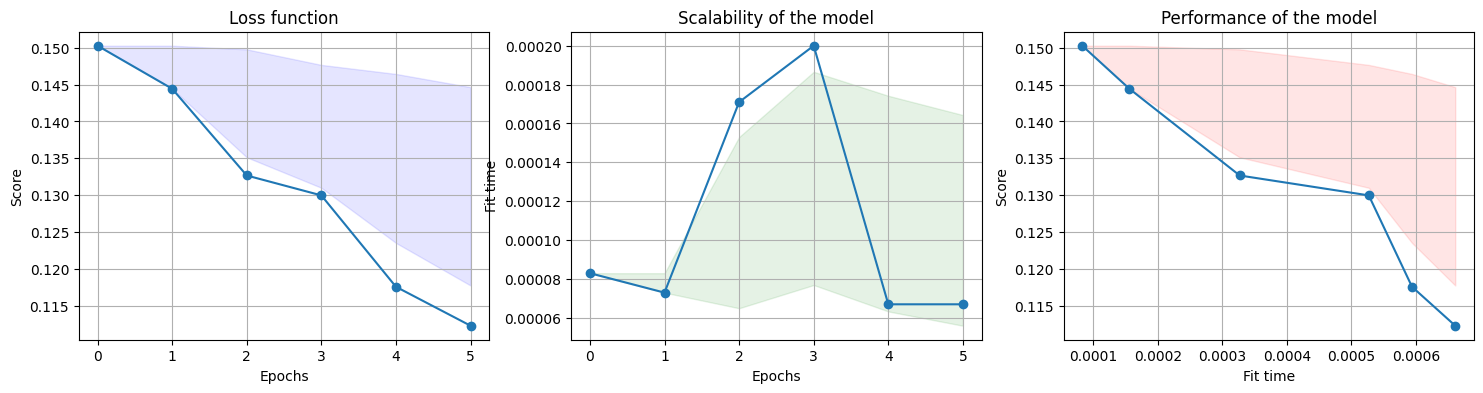

In [19]:
prompt_tuner.plot_learning_curve()

<a id="deploy"></a>
## Deploy

You can specify `model_id` from tuning details.

In [20]:
model_id = None

if 'model_id' in tuning_details.get('entity', {}):
    model_id = tuning_details['entity']['model_id']
model_id

'56eca911-dc18-42ca-aec2-f5f43e0b0383'

Create online deployment for published model.

In [21]:
from datetime import datetime
meta_props = {
    client.deployments.ConfigurationMetaNames.NAME: "PT DEPLOYMENT SDK - project",
    client.deployments.ConfigurationMetaNames.ONLINE: {},
    client.deployments.ConfigurationMetaNames.SERVING_NAME : f"pt_sdk_deployment_{datetime.utcnow().strftime('%Y_%m_%d_%H%M%S')}"
}
deployment_details = client.deployments.create(model_id, meta_props)



#######################################################################################

Synchronous deployment creation for uid: '56eca911-dc18-42ca-aec2-f5f43e0b0383' started

#######################################################################################


initializing.
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='a1311d99-b1cd-4040-8f6e-db544d44b4a5'
------------------------------------------------------------------------------------------------




Additionally you can get deployment details by printing `deployment_details`

In [ ]:
deployment_details

You can specify `deployment_id` from deployment details.

In [23]:
deployment_id = deployment_details['metadata']['id']
deployment_id

'a1311d99-b1cd-4040-8f6e-db544d44b4a5'

<a id="models_inference"></a>
## Foundation Models Inference on `watsonx.ai`

Provide a set of model parameters.

In [24]:
from ibm_watsonx_ai.metanames import GenTextParamsMetaNames as GenParams

generate_params = {
    GenParams.MAX_NEW_TOKENS: 3,
    GenParams.STOP_SEQUENCES: ["\n\n"]
}

Initialize the `ModelInference` class.

In [25]:
from ibm_watsonx_ai.foundation_models import ModelInference

tuned_model = ModelInference(
    deployment_id=deployment_id,
    params=generate_params,
    api_client=client
)

Alternatively you can use `credentials` and `project_id` to initialize the `ModelInference` class.

```
tuned_model = ModelInference(
    deployment_id=deployment_id,
    params=generate_params,
    credentials=credentials,
    project_id=project_id
)

```

Get deployment model inference details.

In [ ]:
tuned_model.get_details()

Analyze the product class for a sample prompt.

In [27]:
response = tuned_model.generate_text(prompt="Extract the satisfaction from the comment. Return simple 1 for satisfied customer or 0 for unsatisfied.\nComment: I was penalty charged because vehicle was not returned with full tank.\nSatisfaction:\n")
response

'0'

<a id="predict"></a>
## Analyze the product classes.

Download and prepare the `cfpb_test` dataset.

In [28]:
import pandas as pd

filename = 'car_rental_prompt_tuning_testing_data.json'

url = "https://raw.github.com/IBM/watson-machine-learning-samples/master/cloud/data/prompt_tuning/car_rental_prompt_tuning_testing_data.json"
if not os.path.isfile(filename):
    wget.download(url)

data = pd.read_json(filename)
prompts = list(data.input)
satisfaction = list(data.output)
prompts_batch = ["\n".join([prompt]) for prompt in prompts]

### Calculate the accuracy of tuned model

In [29]:
tuned_model_results = tuned_model.generate_text(prompt=prompts_batch)

In [30]:
tuned_model_results = [int(x) for x in tuned_model_results]

In [31]:
from sklearn.metrics import accuracy_score

print(f'accuracy_score: {accuracy_score(satisfaction, tuned_model_results)}')

accuracy_score: 0.916083916083916


### Calculate the accuracy of base model

Initialize the `ModelInference` class with base model.

In [32]:
base_model = ModelInference(
    model_id='ibm/granite-13b-instruct-v2',
    params=generate_params,
    api_client=client
)

In [33]:
base_model_results = base_model.generate_text(prompt=prompts_batch)

In [34]:
base_model_results = [int(x) for x in base_model_results]

In [35]:
from sklearn.metrics import accuracy_score

print(f'base model accuracy_score: {accuracy_score(satisfaction, base_model_results)}')

base model accuracy_score: 0.8181818181818182


<a id="summary"></a>
## Summary and next steps

 You successfully completed this notebook!
 
 You learned how to use prompt tuning in watsonx for analyze the product classes for a sample prompts.
 
Check out our _<a href="https://ibm.github.io/watson-machine-learning-sdk/samples.html" target="_blank" rel="noopener no referrer">Online Documentation</a>_ for more samples, tutorials, documentation, how-tos, and blog posts. 

### Authors: 

**Lukasz Cmielowski, PhD**, Senior Technical Staff Member at Watson Machine Learning.

**Mateusz Szewczyk**, Software Engineer at Watson Machine Learning.

Copyright © 2024 IBM. This notebook and its source code are released under the terms of the MIT License.